In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import re
sns.set_theme(style="darkgrid")


In [38]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

In [39]:
print(train_df.shape, test_df.shape)

(1216553, 13) (5463, 12)


In [40]:
seoul_df = train_df[train_df['city'] == '서울특별시']
busan_df = train_df[train_df['city'] == '부산광역시']

In [41]:
print(len(seoul_df), len(busan_df), len(seoul_df) + len(busan_df))

742285 474268 1216553


In [42]:
train_df['dong'].nunique()

473

In [43]:
train_df['apt'].nunique()

10440

In [44]:
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt'])   

100%|██████████| 5463/5463 [00:00<00:00, 154972.66it/s]


In [45]:
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt'])   

train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

# top 10 시공사 아파트 여부를 나타내는 컬럼 생성
train_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1

# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train_df['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'

# 아파트별 가격의 평균 내림차순 정렬
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    train_df.loc[train_df['apt'] == a, 'apt'] = i # 라벨 인코딩
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', train_df['year_of_completion'].unique()[:5])
train_df['year_of_completion'] = train_df['year_of_completion'] - train_df['year_of_completion'].min()
print('변환후\n', train_df['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train_df['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train_df['transaction_year_month'] = le.fit_transform(train_df['transaction_year_month'])
# test는 다음과 같이 처리
print('train 변환후\n', train_df['transaction_year_month'].unique()[:5])

# 필요없는 열 제거
train_df = train_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

seoul_set = set(test_df.loc[test_df['city']=='서울특별시', 'dong'])
busan_set = set(test_df.loc[test_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

for d in same_dong:
    train_df.loc[(train_df['city']=='서울특별시') & (train_df['dong']==d), 'dong'] = '서울' + d
    train_df.loc[(train_df['city']=='부산광역시') & (train_df['dong']==d), 'dong'] = '부산' + d
    test_df.loc[(test_df['city']=='서울특별시') & (test_df['dong']==d), 'dong'] = '서울' + d
    test_df.loc[(test_df['city']=='부산광역시') & (test_df['dong']==d), 'dong'] = '부산' + d
    

seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)

# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    train_df.loc[train_df['dong'] == d, 'dong'] = i
    test_df.loc[test_df['dong'] == d, 'dong'] = i
train_df.head()

# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', train_df['floor'].values[:5])
train_df['floor'] = train_df['floor'].map(lambda x: x+4)
test_df['floor'] = test_df['floor'].map(lambda x: x+1)
print('변환후\n', train_df['floor'].values[:5])

# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price'] = np.log1p(train_df['transaction_real_price'])

# 면적 로그 변환 후 원래 면적 따로 저장
train_df['log_area'] = np.log1p(train_df['exclusive_use_area'])

drop_col = ['transaction_id', 'apartment_id', 'apt_counts', 'transformed']

train_df['city'] = train_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test_df['city'] = test_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)

train_df.drop(drop_col, axis=1, inplace=True)

100%|██████████| 25/25 [00:00<00:00, 68.04it/s]


변환전
 apt
잠실      91273.525326
파크리오    88739.646736
자이      79838.112467
래미안     64184.531289
아이파크    63115.982726
Name: transaction_real_price, dtype: float64
변환후
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64
변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
train 변환후
 [0 1 2 3 4]
{'중동', '부암동', '사직동', '송정동'}
{'중동', '부암동', '사직동', '송정동'}
set()


100%|██████████| 477/477 [00:23<00:00, 20.68it/s]


변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


ValueError: invalid literal for int() with base 10: '청학'

In [46]:
train_df['dong'] = train_df['dong'].astype('int64')
train_df['apt'] = train_df['apt'].astype('int64')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  int64  
 2   apt                     1216553 non-null  int64  
 3   exclusive_use_area      1216553 non-null  float64
 4   year_of_completion      1216553 non-null  int64  
 5   transaction_year_month  1216553 non-null  int64  
 6   floor                   1216553 non-null  int64  
 7   transaction_real_price  1216553 non-null  int64  
 8   top10                   1216553 non-null  int64  
 9   log_price               1216553 non-null  float64
 10  log_area                1216553 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 111.4 MB


In [49]:
train_df.head()

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area
0,1,138,23,84.82,41,0,6,37500,0,10.532123,4.452252
1,1,65,23,99.17,12,0,10,20000,0,9.903538,4.606869
2,1,65,23,84.74,46,0,10,38500,0,10.558439,4.451319
3,1,13,23,146.39,42,0,19,118000,0,11.678448,4.993082
4,1,13,23,194.43,43,0,7,120000,0,11.695255,5.275202


In [50]:
# dataframe sampling 1%
sample = train_df.sample(frac=5e-4, random_state=42)
print(sample.shape)

(608, 11)


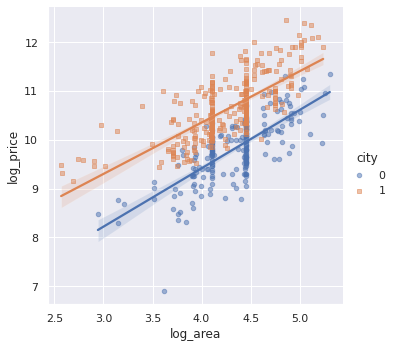

In [62]:
sns.lmplot(x='log_area', y='log_price', hue='city', data=sample, markers=['o', 's'], scatter_kws={'alpha':0.5, 's':20})
plt.show()

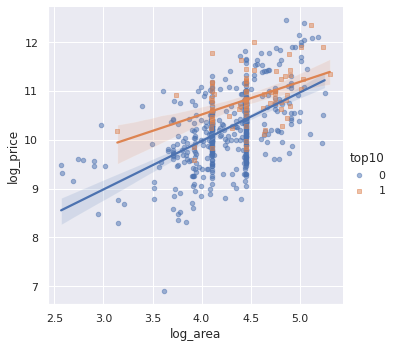

In [63]:
sns.lmplot(x='log_area', y='log_price', hue='top10', data=sample, markers=['o', 's'], scatter_kws={'alpha':0.5, 's':20})
plt.show()

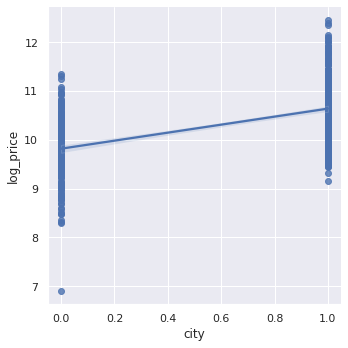

In [74]:
sns.lmplot(x='city', y='log_price', data=sample)
plt.show()

[]

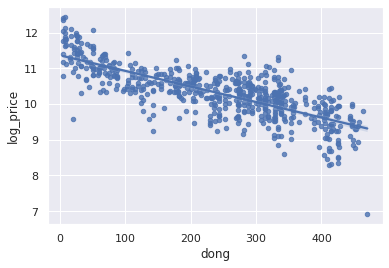

In [60]:
sns.regplot(x='dong', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

[]

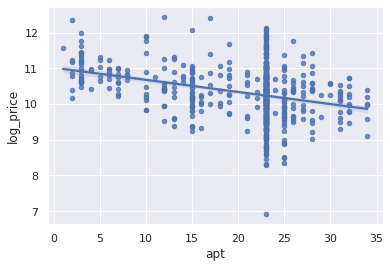

In [68]:
sns.regplot(x='apt', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

[]

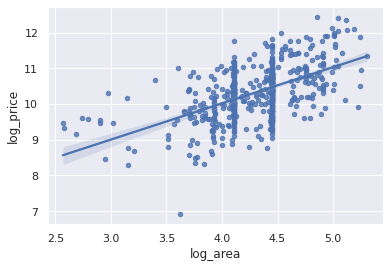

In [75]:
sns.regplot(x='log_area', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

[]

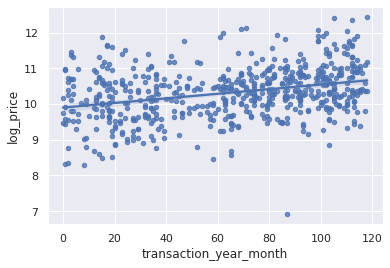

In [70]:
sns.regplot(x='transaction_year_month', y='log_price', data=sample, scatter_kws={'s': 20})
plt.plot()

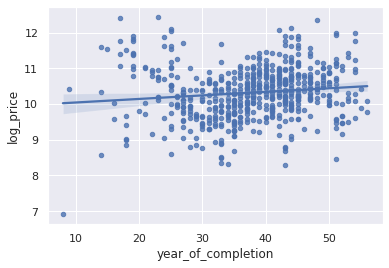

In [71]:
sns.regplot(x='year_of_completion', y='log_price', data=sample, scatter_kws={'s': 20})
plt.show()

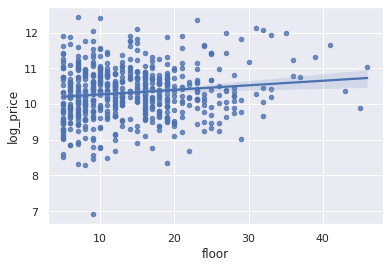

In [72]:
sns.regplot(x='floor', y='log_price', data=sample, scatter_kws={'s': 20})
plt.show()